In [1]:
import sys # for gioia to load aiohttp
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

# to import modules locally without having installed the entire package
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

import time
import signal
import subprocess
import numpy as np
from scipy.stats import norm
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

In [2]:
from timeseries import *
from webserver import *

Generating LALR tables


In [3]:
def tsmaker(m, s, j):
    '''
    Helper function: randomly generates a time series for testing.

    Parameters
    ----------
    m : float
        Mean value for generating time series data
    s : float
        Standard deviation value for generating time series data
    j : float
        Quantifies the "jitter" to add to the time series data

    Returns
    -------
    A time series and associated meta data.
    '''

    # generate metadata
    meta = {}
    meta['order'] = int(np.random.choice(
        [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]))
    meta['blarg'] = int(np.random.choice([1, 2]))

    # generate time series data
    t = np.arange(0.0, 1.0, 0.01)
    v = norm.pdf(t, m, s) + j * np.random.randn(ts_length)

    # return time series and metadata
    return meta, TimeSeries(t, v)

In [4]:
# load stock data
with open('data/prices_exclude.json') as f:    
    stock_data_exclude = json.load(f)

# keep track of which stocks are included/excluded from the database
stocks_exclude = list(stock_data_exclude.keys())
    
# check the number of market days in the year
num_days = len(stock_data_exclude[stocks_exclude[0]])

# Time series database & similarity searches

Gioia Dominedo  
Nicolas Drizard  
Kendrick Lo  

## Persistence architecture

<img src='img/db_structure.png'>

# Persistence demonstration

## Initialize file system

In [5]:
# database parameters
ts_length = 100
data_dir = '../db_files'
db_name = 'default'
dir_path = data_dir + '/' + db_name + '/'

In [6]:
# clear file system for testing
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
filelist = [dir_path + f for f in os.listdir(dir_path)]
for f in filelist:
    os.remove(f)

## Initialize database

In [7]:
# load the server
server = subprocess.Popen(['python', '../go_server_persistent.py',
                           '--ts_length', str(ts_length), '--data_dir', data_dir, '--db_name', db_name])
time.sleep(5)  # make sure it loads completely

# load the webserver
webserver = subprocess.Popen(['python', '../go_webserver.py'])
time.sleep(5)  # make sure it loads completely

# initialize the web interface
web_interface = WebInterface()

In [8]:
# check that the database is empty
web_interface.select()

OrderedDict()

## Generate data

In [9]:
# generate sample time series
num_ts = 50
mus = np.random.uniform(low=0.0, high=1.0, size=num_ts)
sigs = np.random.uniform(low=0.05, high=0.4, size=num_ts)
jits = np.random.uniform(low=0.05, high=0.2, size=num_ts)

# initialize dictionaries for time series and their metadata
primary_keys = []
tsdict = {}
metadict = {}

# fill dictionaries with randomly generated entries for database
for i, m, s, j in zip(range(num_ts), mus, sigs, jits):
    meta, tsrs = tsmaker(m, s, j)  # generate data
    pk = "ts-{}".format(i)  # generate primary key
    primary_keys.append(pk) # keep track of all primary keys
    tsdict[pk] = tsrs  # store time series data
    metadict[pk] = meta  # store metadata
    
# to assist with later testing
ts_keys = sorted(tsdict.keys())
    
# randomly choose time series as vantage points
num_vps = 5
vpkeys = list(np.random.choice(ts_keys, size=num_vps, replace=False))
vpdist = ['d_vp_{}'.format(i) for i in vpkeys]

## Insert data

In [10]:
# add stats trigger
web_interface.add_trigger('stats', 'insert_ts', ['mean', 'std'], None)

# insert the time series
for k in tsdict:
    web_interface.insert_ts(k, tsdict[k])
    
# upsert the metadata
for k in tsdict:
    web_interface.upsert_meta(k, metadict[k])
    
# add the vantage points
for i in range(num_vps):
    web_interface.insert_vp(vpkeys[i])

## Inspect data

### Are all the entries there?

In [11]:
# select all database entries; all metadata fields
results = web_interface.select(fields=[])

# we have the right number of database entries
assert len(results) == num_ts

# we have all the right primary keys
assert sorted(results.keys()) == ts_keys

### Does the data match?

In [12]:
# check that all the time series and metadata matches
for k in tsdict:
    results = web_interface.select(fields=['ts'], md={'pk': k})
    assert results[k]['ts'] == tsdict[k]
    results = web_interface.select(fields=[], md={'pk': k})
    for field in metadict[k]:
        assert metadict[k][field] == results[k][field]

### Did the triggers work?

In [13]:
# check that the trigger has executed as expected (allowing for rounding errors)
for k in tsdict:
    results = web_interface.select(fields=['mean', 'std'], md={'pk': k})
    assert np.round(results[k]['mean'], 4) == np.round(tsdict[k].mean(), 4)
    assert np.round(results[k]['std'], 4) == np.round(tsdict[k].std(), 4)

### Were the vantage points inserted?

In [14]:
# check that the vantage points match
print('Vantage points selected:', vpkeys)
print('Vantage points in database:',
      web_interface.select(fields=None, md={'vp': True}, additional={'sort_by': '+pk'}).keys(), '\n')

# check that the vantage point distance fields have been created
results = web_interface.select(fields=vpdist, additional={'sort_by': '+pk', 'limit': 1})
print('Vantage point distance fields:', vpdist)
print('Vantage point distance example:')
print(results)

Vantage points selected: ['ts-17', 'ts-33', 'ts-24', 'ts-14', 'ts-48']
Vantage points in database: odict_keys(['ts-14', 'ts-17', 'ts-24', 'ts-33', 'ts-48']) 

Vantage point distance fields: ['d_vp_ts-17', 'd_vp_ts-33', 'd_vp_ts-24', 'd_vp_ts-14', 'd_vp_ts-48']
Vantage point distance example:
OrderedDict([('ts-0', OrderedDict([('d_vp_ts-24', 0.9382036924362183), ('d_vp_ts-33', 0.9104697108268738), ('d_vp_ts-48', 0.8504132032394409), ('d_vp_ts-17', 0.8862289786338806), ('d_vp_ts-14', 0.9653292298316956)]))])


## Terminate database

In [15]:
os.kill(server.pid, signal.SIGINT)
time.sleep(5)  # give it time to terminate
os.kill(webserver.pid, signal.SIGINT)
time.sleep(5)  # give it time to terminate
web_interface = None

## Reload database

In [16]:
server = subprocess.Popen(['python', '../go_server_persistent.py',
                           '--ts_length', str(ts_length), '--data_dir', data_dir, '--db_name', db_name])
time.sleep(5)  # give it time to load fully
webserver = subprocess.Popen(['python', '../go_webserver.py'])
time.sleep(5)  # give it time to load fully
web_interface = WebInterface()

## ... once more, with feeling!

### Are all the entries there?

In [17]:
# select all database entries; all metadata fields
results = web_interface.select(fields=[])

# we have the right number of database entries
assert len(results) == num_ts

# we have all the right primary keys
assert sorted(results.keys()) == ts_keys

### Does the data match?

In [18]:
# check that all the time series and metadata matches
for k in tsdict:
    results = web_interface.select(fields=['ts'], md={'pk': k})
    assert results[k]['ts'] == tsdict[k]
    results = web_interface.select(fields=[], md={'pk': k})
    for field in metadict[k]:
        assert metadict[k][field] == results[k][field]

### Were the vantage points re-loaded?

In [19]:
# check that the vantage points match
print('Vantage points selected:', vpkeys)
print('Vantage points in database:',
      web_interface.select(fields=None, md={'vp': True}, additional={'sort_by': '+pk'}).keys())

Vantage points selected: ['ts-17', 'ts-33', 'ts-24', 'ts-14', 'ts-48']
Vantage points in database: odict_keys(['ts-14', 'ts-17', 'ts-24', 'ts-33', 'ts-48'])


### Does the trigger still work?

In [20]:
# check that the trigger is still there by loading new data

# create test time series
_, test = tsmaker(np.random.uniform(low=0.0, high=1.0),
                  np.random.uniform(low=0.05, high=0.4),
                  np.random.uniform(low=0.05, high=0.2))

# insert test time series
web_interface.insert_ts('test', test)

# check that mean and standard deviation have been calculated
web_interface.select(fields=['mean', 'std'], md={'pk': 'test'})

OrderedDict([('test',
              OrderedDict([('std', 0.8259448409080505),
                           ('mean', 0.9800808429718018)]))])

## Terminate database

In [21]:
# terminate processes before exiting
os.kill(server.pid, signal.SIGINT)
time.sleep(5)  # give it time to terminate
web_interface = None
webserver.terminate()

## Additional Feature:  
## iSAX Similarity Searches

* Time series T of length n can be converted into a SAX representation
  * approximates T using a smaller number of segments (e.g. w=4)
  * each segment is represented by a discrete number
  * result is a SAX word (i.e. a vector) such as {11, 11, 01, 00}

<img src='img/slide1.png'>

* SAX representation can be used as an index
  * e.g. fixed cardinality of 8, word length of 4
  * An example T may map to $\{6^8, 6^8, 3^8, 0^8\}$ 
    * data for all Ts that can be represented by this SAX word can be stored in the same text file on disk (e.g. with name **6.8_6.8_3.8_0.8.txt**)
* **Problem**: storage imbalance
* **Solution**: introduce a threshold for the number of time series that can be stored in a single file
  * If an insertion would cause threshold to be exceeded, **split the file**

* The diagram below illustrates an iSAX index as a tree
  * **root node**: represents complete SAX space
  * **terminal node**: leaf node containing pointer to file on disk
    * **SAX word** as index, contents are the actual time series data
  * **internal node** (new): designates split in SAX space
    * created when number of entries in a terminal node exceeds threshold

<img src='img/slide3.png'>

* Observations:
  * **binary** splits are along one dimension (sequentially) 
    * creates two new words of increased cardinality
  * “new” node splitting policy (iSAX 2.0) purports to provide better balance by determining optimal dimension
    * checks whether mean value is close to a breakpoint
* However:
  * balancing problems still exist
  * no justification given for binary splits
    * note that root is connected to multiple nodes


<img src='img/slide5.png'>

* We implemented iSAX tree as a “true” n-ary tree
  * splits series in a “full” terminal node into up to ‘n’ terminal nodes all located at the same depth in the tree
  * achieves better balance, faster traversals
* Class methods:
  * insert, delete, preorder (x2), similarity search (find_nbr)

* Similarity search is **“approximate”**
  * intuition is that two similar time series are often  represented by the same iSAX word
  * natural clustering
  * “ties” broken by computing Euclidean distance (but only for neighbors)
   * adjust for sparser nodes by implementing search for series with common parent

<img src='img/slide7.png'>

## Stock market example

### Here's one we prepared earlier...

In [22]:
# load the database server
server = subprocess.Popen(['python', '../go_server_persistent.py',
                           '--ts_length', str(num_days), '--data_dir', '../db_files', '--db_name', 'stock_prices'])
time.sleep(5)  # make sure it loads completely

# load the database webserver
webserver = subprocess.Popen(['python', '../go_webserver.py'])
time.sleep(5)  # make sure it loads completely

# initialize the web interface
web_interface = WebInterface()

### Is there any data?

In [23]:
# number of stocks
len(web_interface.select())

350

### What does it look like?

In [24]:
# let's look at the first 10 stocks
web_interface.select(fields=['ts'], additional={'sort_by': '+pk', 'limit': 10})

OrderedDict([('A',
              OrderedDict([('ts',
                            TimeSeries(Length: 245 [25.55, ..., 28.56]))])),
             ('AA',
              OrderedDict([('ts',
                            TimeSeries(Length: 245 [12.56, ..., 10.57]))])),
             ('ABC',
              OrderedDict([('ts',
                            TimeSeries(Length: 245 [21.05, ..., 28.92]))])),
             ('ABT',
              OrderedDict([('ts',
                            TimeSeries(Length: 245 [45.39, ..., 49.34]))])),
             ('ADI',
              OrderedDict([('ts',
                            TimeSeries(Length: 245 [28.42, ..., 29.62]))])),
             ('ADM',
              OrderedDict([('ts',
                            TimeSeries(Length: 245 [28.67, ..., 30.52]))])),
             ('AEE',
              OrderedDict([('ts',
                            TimeSeries(Length: 245 [27.05, ..., 27.14]))])),
             ('AEP',
              OrderedDict([('ts',
                        

### Can we run a vantage point search?

In [25]:
# pick a stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]), 1)
stock_match = list(result)[0]
stock_ts = web_interface.select(fields=['ts'], md={'pk': stock_match})[stock_match]['ts']
print('Most similar stock:', stock_match)

Stock: CB
Most similar stock: DD


### How do the stocks compare?

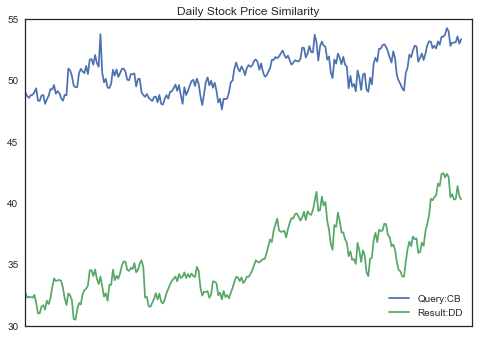

In [26]:
# visualize similarity
plt.plot(stock_data_exclude[stock], label='Query:' + stock)
plt.plot(stock_ts.values(), label='Result:' + stock_match)
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Price Similarity')
plt.show()

### Can we run an iSAX tree similarity search?

In [27]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the isax tree similarity search
result = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]))

if result == 'ERROR: NO_MATCH':
    print('Could not find a similar stock.')
else:
    stock_match = list(result)[0]
    stock_ts = web_interface.select(fields=['ts'], md={'pk': stock_match})[stock_match]['ts']
    print('Most similar stock:', stock_match)

Stock: GWW
Most similar stock: PNC


### How do the stocks compare?

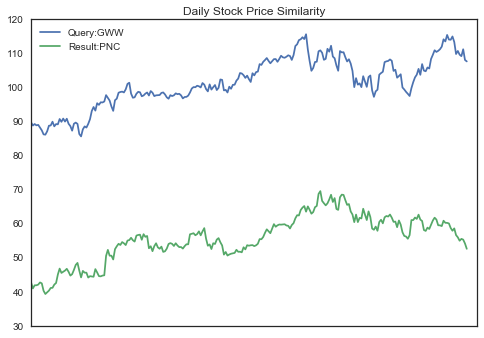

In [28]:
# visualize similarity
plt.plot(stock_data_exclude[stock], label='Query:' + stock)
plt.plot(stock_ts.values(), label='Result:' + stock_match)
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Price Similarity')
plt.show()

### How do the methods compare?

In [29]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]), 1)
match_vp = list(result)[0]
ts_vp = web_interface.select(fields=['ts'], md={'pk': match_vp})[match_vp]['ts']
print('VP search result:', match_vp)

# run the isax similarity search
result = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]))
if result == 'ERROR: NO_MATCH':
    print('iSAX search result: Could not find a similar stock.')
else:
    match_isax = list(result)[0]
    ts_isax = web_interface.select(fields=['ts'], md={'pk': match_isax})[match_isax]['ts']
    print('iSAX search result:', match_isax)

Stock: CAH
VP search result: HNZ
iSAX search result: SNA


### Show me another graph!

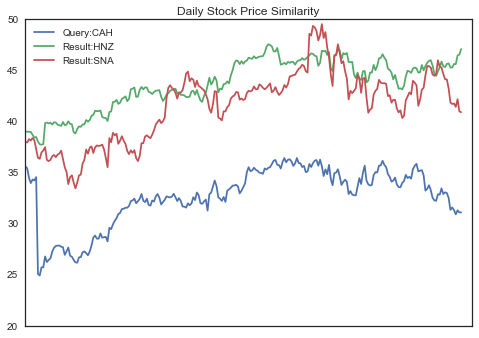

In [30]:
# visualize similarity
plt.plot(stock_data_exclude[stock], label='Query:' + stock)
plt.plot(ts_vp.values(), label='Result:' + match_vp)
plt.plot(ts_isax.values(), label='Result:' + match_isax)
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Price Similarity')
plt.show()

### What is an iSAX tree, really?

In [31]:
print(web_interface.isax_tree())

root
--->['11', '10', '00', '10']: 0 []
------>['110', '100', '000', '100']: 3 ['A', 'JCI', 'PKI']
------>['110', '101', '000', '100']: 2 ['CCL', 'FO']
------>['110', '101', '000', '101']: 1 ['LMT']
------>['110', '100', '000', '101']: 1 ['USB']
--->['00', '11', '00', '11']: 1 ['JEC']
--->['11', '01', '00', '01']: 0 []
------>['111', '011', '001', '010']: 3 ['AXP', 'GAS', 'NI']
------>['110', '011', '001', '011']: 1 ['APH']
------>['111', '010', '001', '011']: 4 ['AMD', 'BMS', 'HRS', 'PG']
------>['111', '011', '001', '011']: 4 ['GCI', 'MMM', 'SLM', 'WM']
--->['10', '01', '01', '11']: 4 ['FCX', 'HAL', 'NSM', 'SLB']
--->['11', '10', '00', '01']: 0 []
------>['110', '100', '001', '011']: 4 ['FTI', 'PLL', 'TER', 'TMO']
------>['110', '101', '001', '010']: 0 []
--------->['1101', '1010', '0010', '0101']: 1 ['UPS']
--------->['1101', '1010', '0011', '0100']: 1 ['CSX']
--------->['1101', '1011', '0010', '0100']: 2 ['DRI', 'PPG']
--------->['1101', '1010', '0010', '0100']: 1 ['KFT']
---------

## Don't forget to close the server!

In [32]:
# terminate processes before exiting
os.kill(server.pid, signal.SIGINT)
time.sleep(5)  # give it time to terminate
web_interface = None
webserver.terminate()

# Any questions?